In [75]:
import summer2

In [76]:
from jax import lax, jit, numpy as jnp
import numpy as np
import pandas as pd

In [77]:
from emu_renewal.renew import RenewalModel

In [78]:
m = RenewalModel(50000.0, 300, 10, 4)

<Axes: >

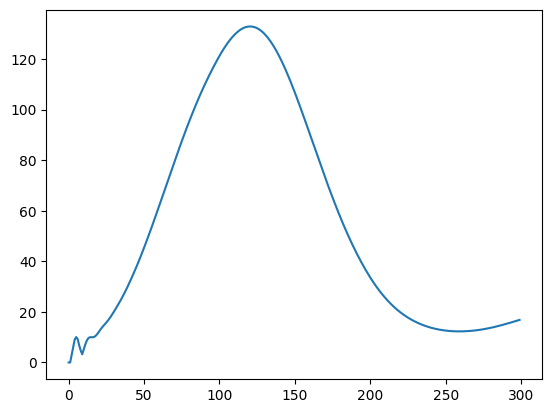

In [79]:
pd.Series(m.func(8.5,3.0,np.array([0.5,0.2,0.1,0.5]),10.0).incidence).plot()

In [80]:
from typing import NamedTuple

class RenewalState(NamedTuple):
    incidence: jnp.array
    suscept: float

    



In [81]:
from jax.scipy.stats.gamma import cdf

In [82]:
m.seeder.get_interp_func([0.0,5.0])(8.0)

array(0.)

In [83]:
def get_densities(window_len, mean, sd):
    scale = (sd*sd)/mean
    a = mean/scale
    return jnp.diff(cdf(jnp.arange(window_len+1),a=a,scale=scale))

In [84]:
m.dens_obj.get_densities(30,10,2)

array([5.19810028e-17, 1.59958588e-10, 3.74818966e-07, 4.65744025e-05,
       1.14549947e-03, 9.97233142e-03, 4.20115236e-02, 1.03596318e-01,
       1.69434265e-01, 2.00394644e-01, 1.82388168e-01, 1.33768273e-01,
       8.18814160e-02, 4.29865015e-02, 1.97773700e-02, 8.11408320e-03,
       3.01094585e-03, 1.02246450e-03, 3.20869183e-04, 9.38277236e-05,
       2.57462232e-05, 6.66957002e-06, 1.63965192e-06, 3.84280624e-07,
       8.62017918e-08, 1.85727634e-08, 3.85545529e-09, 7.73234032e-10,
       1.50193746e-10, 2.83176815e-11])

In [85]:
get_densities(30,10.0,2.0)

Array([5.19810028e-17, 1.59958588e-10, 3.74818966e-07, 4.65744025e-05,
       1.14549947e-03, 9.97233142e-03, 4.20115236e-02, 1.03596318e-01,
       1.69434265e-01, 2.00394644e-01, 1.82388168e-01, 1.33768273e-01,
       8.18814160e-02, 4.29865015e-02, 1.97773700e-02, 8.11408320e-03,
       3.01094585e-03, 1.02246450e-03, 3.20869183e-04, 9.38277236e-05,
       2.57462232e-05, 6.66957002e-06, 1.63965192e-06, 3.84280624e-07,
       8.62017918e-08, 1.85727634e-08, 3.85545529e-09, 7.73234032e-10,
       1.50193746e-10, 2.83176815e-11], dtype=float64)

In [98]:
@jit
def model_func(gen_time_mean, gen_time_sd, population, init_state):
    
    densities = get_densities(30, gen_time_mean, gen_time_sd)

    def state_update(state: RenewalState, t) -> (RenewalState, jnp.array):
        r_t = state.suscept / population
        renewal = (densities * state.incidence).sum() * r_t
        suscept = state.suscept - renewal
        suscept = jnp.where(suscept > 0, suscept, 0.0)
        incidence = jnp.zeros_like(state.incidence)
        incidence = incidence.at[1:].set(state.incidence[:-1])
        incidence = incidence.at[0].set(renewal)
        return RenewalState(incidence, suscept), jnp.array([renewal, suscept])

    end_state, outputs = lax.scan(state_update, init_state, jnp.arange(3000))

    return outputs

In [99]:
jnp.roll(np.arange(30),5)

Array([25, 26, 27, 28, 29,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], dtype=int32)

In [100]:
(-1-5)%30

24

In [101]:
@jit
def model_funcrb(gen_time_mean, gen_time_sd, population, init_state):
    
    densities = get_densities(30, gen_time_mean, gen_time_sd)

    def state_update(state: RenewalState, t) -> (RenewalState, jnp.array):
        r_t = state.suscept / population
        incidence_history = jnp.roll(state.incidence, t%30)
        renewal = (densities * incidence_history).sum() * r_t
        suscept = state.suscept - renewal
        suscept = jnp.where(suscept > 0, suscept, 0.0)
        rb_idx = t % 30

        #incidence = incidence.at[].set(state.incidence[:-1])
        incidence = state.incidence.at[(-1-t)%30].set(renewal)
        return RenewalState(incidence, suscept), jnp.array([renewal, suscept])

    end_state, outputs = lax.scan(state_update, init_state, jnp.arange(3000))

    return outputs

In [102]:
WLEN = 30
densities = m.dens_obj.get_densities(WLEN,8.0,2.0)
init_incidence = np.zeros(WLEN)
init_incidence[:] = 1.0


%timeit model_func(8.0, 2.0, 1000.0, RenewalState(init_incidence, 1000.0))

136 µs ± 8.32 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%timeit model_funcrb(8.0, 2.0, 1000.0, RenewalState(init_incidence, 1000.0))

133 µs ± 9.65 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [106]:
%timeit model_func(8.0, 2.0, 1000.0, RenewalState(init_incidence, 1000.0))

136 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<Axes: >

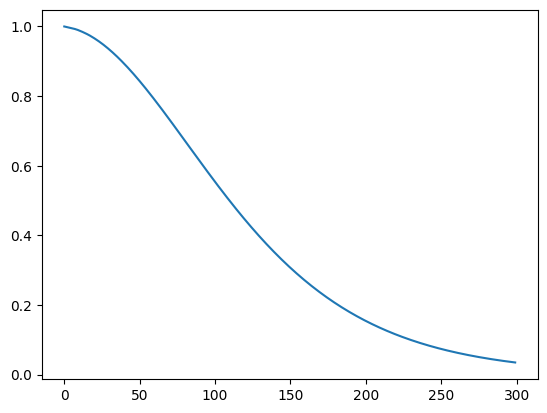

In [93]:
pd.Series(model_funcrb(8.0,2.0, 1000.0, RenewalState(init_incidence, 1000.0))[:,0]).plot()

<Axes: >

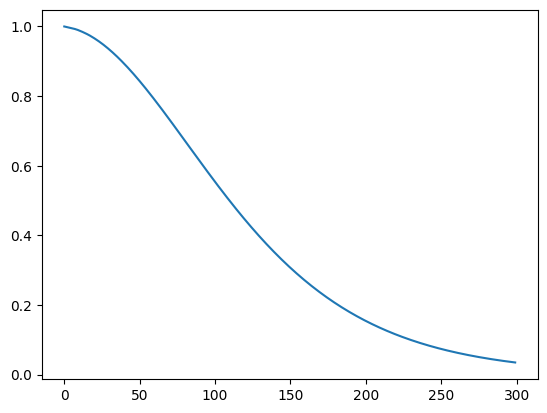

In [92]:
pd.Series(model_func(8.0,2.0, 1000.0, RenewalState(init_incidence, 1000.0))[:,0]).plot()

In [41]:
%%time
do_scan(-1.0)

CPU times: total: 0 ns
Wall time: 0 ns


Array([[ 0.0000e+00, -2.0000e+00,  1.0000e+00],
       [ 1.0000e+00, -4.0000e+00, -2.0000e+00],
       [ 2.0000e+00, -1.6000e+01, -4.0000e+00],
       [ 3.0000e+00, -2.5600e+02, -1.6000e+01],
       [ 4.0000e+00, -6.5536e+04, -2.5600e+02]], dtype=float32)

In [24]:
outputs 

Array([[0.0000e+00, 2.0000e+00, 1.0000e+00],
       [1.0000e+00, 4.0000e+00, 2.0000e+00],
       [2.0000e+00, 1.6000e+01, 4.0000e+00],
       [3.0000e+00, 2.5600e+02, 1.6000e+01],
       [4.0000e+00, 6.5536e+04, 2.5600e+02]], dtype=float32)